# Topology Wars
## Classification of RepliSage Structures

Here we load the libraries

In [66]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from pathlib import Path
from tqdm import tqdm

In [69]:
from RepliSage.utils import get_coordinates_cif

def extract_label(filename: str) -> str:
    if 'AR' in filename:
        return 'AR'
    elif 'BR' in filename:
        return 'BR'
    elif 'R' in filename:
        return 'R'
    else:
        raise ValueError(f"Unknown label in filename: {filename}")

def extract_features(coords: np.ndarray) -> np.ndarray:
    """Flatten the coordinate array. Adapt as needed for better features."""
    return coords.flatten()

def load_dataset(folder: str):
    X = []
    y = []
    files = list(Path(folder).glob("ensemble*R*.cif"))
    for file in tqdm(files, desc="Loading structures"):
        coords = get_coordinates_cif(str(file))  # returns shape (N,3)
        coords = coords[:len(coords)//2]
        label = extract_label(file.name)
        X.append(extract_features(coords))
        y.append(label)
    return np.array(X), np.array(y)

In [131]:
folder = "/home/skorsak/Data/Simulations/Topology_Wars/RepliSage_results/RepliSage_Tinit_1.6_ht/ensemble"  # Change this to your path
print("Loading data...")
X, y = load_dataset(folder)

Loading data...


Loading structures: 100%|████████████████████████████████████████████████████████████████████████| 975/975 [01:15<00:00, 12.96it/s]


In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)  # Mean 0, variance 1

In [133]:
X.shape

(975, 6000)

In [134]:
print("Splitting...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting...


In [135]:
X_train[0].shape

(6000,)

In [136]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "RandomForest": RandomForestClassifier()
}

It looks like it is pretty simple to train a model to distinguish between phases of RepliSage. This is good because it means that RepliSage works!

In [137]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred))


Training LogisticRegression...
Results for LogisticRegression:
              precision    recall  f1-score   support

          AR       1.00      1.00      1.00       152
          BR       1.00      0.96      0.98        23
           R       0.95      1.00      0.98        20

    accuracy                           0.99       195
   macro avg       0.98      0.99      0.98       195
weighted avg       1.00      0.99      0.99       195


Training SVM...
Results for SVM:
              precision    recall  f1-score   support

          AR       1.00      1.00      1.00       152
          BR       1.00      1.00      1.00        23
           R       1.00      1.00      1.00        20

    accuracy                           1.00       195
   macro avg       1.00      1.00      1.00       195
weighted avg       1.00      1.00      1.00       195


Training RandomForest...
Results for RandomForest:
              precision    recall  f1-score   support

          AR       1.00      1.00

## Clustering and Dimensionality Reduction of the 3D Structures

Let's see how unsupervised algorithms behave.

In [138]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler

In [139]:
def reduce_and_plot(X, y, method="pca"):
    X_scaled = StandardScaler().fit_transform(X)

    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=10, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unknown method")

    X_reduced = reducer.fit_transform(X_scaled)

    # Plotting
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        mask = (y == label)
        plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], label=label, alpha=0.7)
    plt.title(f"2D Projection using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

Projecting with PCA


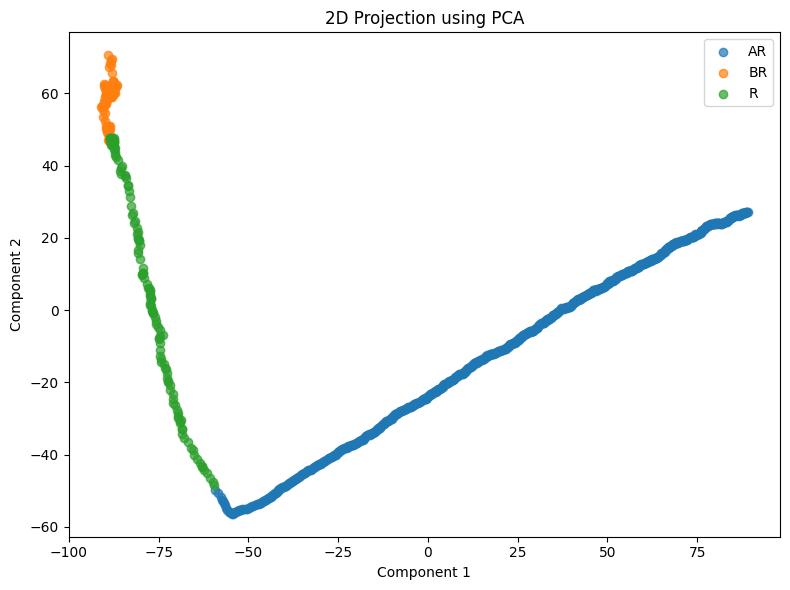

Projecting with TSNE


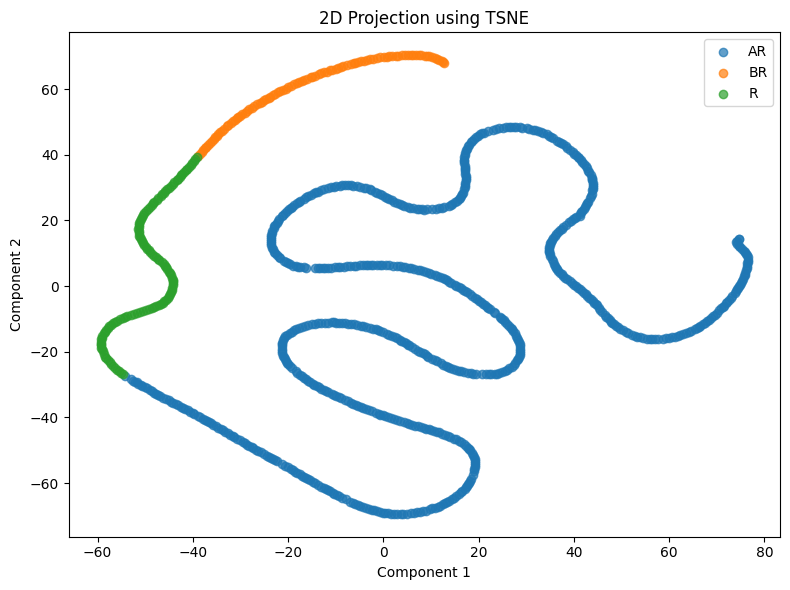

Projecting with UMAP


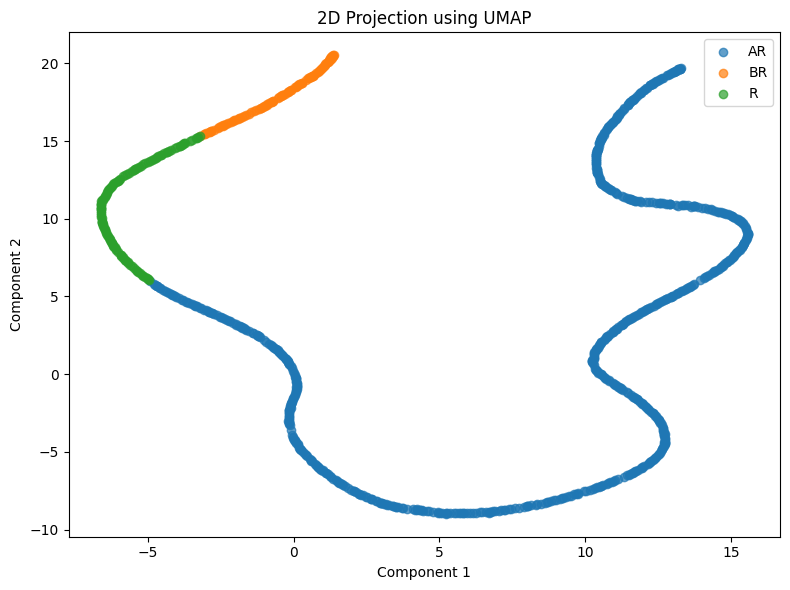

In [140]:
for method in ["pca", "tsne", "umap"]:
    print(f"Projecting with {method.upper()}")
    reduce_and_plot(X, y, method=method)

## Can we predict the structure with ML??

In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# ==== Parameters ====
LATENT_DIM = 128
HIDDEN_DIM = 256
EPOCHS = 100
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== cVAE model ====
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + label_dim, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(HIDDEN_DIM, latent_dim)
        self.fc_logvar = nn.Linear(HIDDEN_DIM, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + label_dim, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, input_dim),
        )

    def encode(self, x, y):
        z_in = torch.cat([x, y], dim=1)
        h = self.encoder(z_in)
        mu = self.fc_mu(h)
        logvar = torch.clamp(self.fc_logvar(h), min=-10, max=10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z_in = torch.cat([z, y], dim=1)
        return self.decoder(z_in)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar

# ============ Define a Loss Function ============
def random_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.5)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def bond_length_loss(x, recon_x):
    x_coords = x.view(x.size(0), -1, 3)
    r_coords = recon_x.view(recon_x.size(0), -1, 3)
    x_diffs = x_coords[:, 1:] - x_coords[:, :-1]
    r_diffs = r_coords[:, 1:] - r_coords[:, :-1]
    x_dists = torch.norm(x_diffs, dim=-1)
    r_dists = torch.norm(r_diffs, dim=-1)
    return F.mse_loss(r_dists, x_dists)  # compare to input distances

def planarity_penalty(coords):
    coords = coords.view(coords.size(0), -1, 3)
    z_var = torch.var(coords[:, :, 2], dim=1)
    return 1.0 - torch.mean(z_var / (torch.var(coords, dim=1).sum(dim=1) + 1e-8))

def self_avoidance_penalty(coords, min_dist=1.0, max_samples=4):
    coords = coords.view(coords.size(0), -1, 3)
    if coords.size(0) > max_samples:
        coords = coords[:max_samples]
    N = coords.size(1)
    dist = torch.cdist(coords, coords, p=2)
    mask = torch.triu(torch.ones_like(dist), diagonal=1)
    close_pairs = (dist < min_dist) & mask.bool()
    num_pairs = (N * (N - 1)) / 2
    return close_pairs.float().sum() / (coords.size(0) * num_pairs + 1e-8)

def rigidity_penalty(coords):
    coords = coords.view(coords.size(0), -1, 3)
    v1 = coords[:, 1:-1] - coords[:, :-2]
    v2 = coords[:, 2:] - coords[:, 1:-1]
    v1_norm = F.normalize(v1, dim=-1)
    v2_norm = F.normalize(v2, dim=-1)
    cos_angles = (v1_norm * v2_norm).sum(dim=-1)
    rigidity = (1 - cos_angles) ** 2  # softer penalty
    return rigidity.mean()

def vae_loss(x, recon_x, mu, logvar,
             epoch,
             beta=1.0,
             bond_weight_max=1.0,
             planarity_weight_max=1.0,
             self_avoidance_weight_max=1.0,
             rigidity_weight_max=1.0,
             min_self_dist=1.0):

    # Annealing factor increases over epochs
    anneal = min(1.0, epoch / 30)

    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    bond_loss = bond_length_loss(x, recon_x)
    planarity_loss = planarity_penalty(recon_x)
    self_avoid_loss = self_avoidance_penalty(recon_x, min_dist=min_self_dist)
    rigidity_loss = rigidity_penalty(recon_x)

    total_loss = (
        recon_loss +
        beta * kld +
        anneal * bond_weight_max * bond_loss +
        anneal * planarity_weight_max * planarity_loss +
        anneal * self_avoidance_weight_max * self_avoid_loss +
        anneal * rigidity_weight_max * rigidity_loss
    )

    return total_loss, recon_loss, kld

# ========== Validation Metrics ===============
def radius_of_gyration(coords):
    coords = coords.reshape(-1, 3)
    center = coords.mean(axis=0)
    return np.sqrt(((coords - center) ** 2).sum(axis=1).mean())

def validate_structures(model, X, y_onehot):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y_onehot, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        recon, _, _ = model(X, y)
        recon = recon.cpu().numpy()
        X = X.cpu().numpy()
    rg_diffs = [abs(radius_of_gyration(X[i]) - radius_of_gyration(recon[i])) for i in range(X.shape[0])]
    return np.mean(rg_diffs)

# =========== Train and Evaluate ==============
def evaluate(model, dataloader, epoch):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            recon, mu, logvar = model(xb, yb)
            loss, _, _ = vae_loss(xb, recon, mu, logvar, epoch=epoch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def train(model, train_loader, val_loader, X_val, y_val, optimizer):
    train_losses, val_losses, rg_errors = [], [], []
    recon_losses, kld_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0
        total_recon = 0
        total_kld = 0
        beta = min(1.0, epoch / 50)  # KL annealing

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            recon, mu, logvar = model(xb, yb)
            loss, recon_l, kld = vae_loss(xb, recon, mu, logvar, beta=beta, epoch=epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_recon += recon_l.item()
            total_kld += kld.item()

        val_loss = evaluate(model, val_loader, epoch)
        rg_err = validate_structures(model, X_val, y_val)

        train_losses.append(total_train_loss / len(train_loader))
        val_losses.append(val_loss)
        rg_errors.append(rg_err)
        recon_losses.append(total_recon / len(train_loader))
        kld_losses.append(total_kld / len(train_loader))

        print(f"Epoch {epoch+1:3d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f} | "
              f"Recon: {recon_losses[-1]:.4f} | KL: {kld_losses[-1]:.4f} | Rg Error: {rg_err:.4f}")

    # Plotting
    epochs = range(1, EPOCHS + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, recon_losses, label='Reconstruction')
    plt.plot(epochs, kld_losses, label='KL')
    plt.title('Loss Components')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, rg_errors, label='Rg Error', color='green')
    plt.title('Rg Error')
    plt.xlabel('Epoch')
    plt.ylabel('|Rg_real - Rg_recon|')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, rg_errors

Preparing data...
Loading model...
Training..
Epoch   1 | Train Loss: 31.5481 | Val Loss: 728.6231 | Recon: 31.5481 | KL: 716.9817 | Rg Error: 8.0839
Epoch   2 | Train Loss: 47.6675 | Val Loss: 586.3452 | Recon: 29.0013 | KL: 656.4991 | Rg Error: 7.6623
Epoch   3 | Train Loss: 57.5744 | Val Loss: 439.1578 | Recon: 26.7136 | KL: 518.3820 | Rg Error: 7.2608
Epoch   4 | Train Loss: 60.6836 | Val Loss: 302.0633 | Recon: 24.5072 | KL: 373.1806 | Rg Error: 6.8808
Epoch   5 | Train Loss: 59.5915 | Val Loss: 204.5868 | Recon: 22.3275 | KL: 259.3425 | Rg Error: 6.4647
Epoch   6 | Train Loss: 55.6568 | Val Loss: 134.4313 | Recon: 20.3080 | KL: 169.0221 | Rg Error: 6.0911
Epoch   7 | Train Loss: 51.1113 | Val Loss: 98.2456 | Recon: 18.3948 | KL: 108.6553 | Rg Error: 5.6906
Epoch   8 | Train Loss: 47.7529 | Val Loss: 77.8264 | Recon: 16.6794 | KL: 76.7391 | Rg Error: 5.2909
Epoch   9 | Train Loss: 44.1035 | Val Loss: 63.2902 | Recon: 14.9731 | KL: 54.7095 | Rg Error: 4.9029
Epoch  10 | Train Loss:

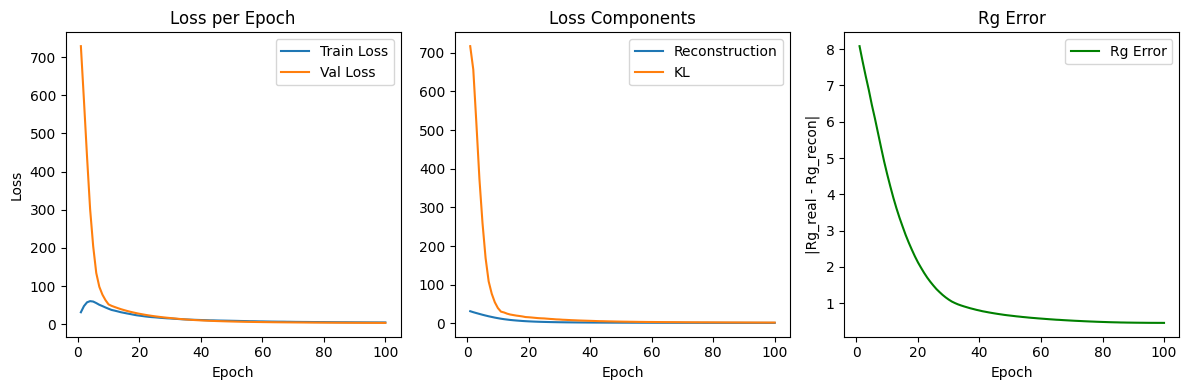

In [277]:
# Label encoding
le = LabelEncoder()
y_int = le.fit_transform(y)
y_onehot = OneHotEncoder(sparse_output=False).fit_transform(y_int.reshape(-1, 1))

# Normalize X (already fixed earlier)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
print('Preparing data...')
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# Dataloaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)),
                        batch_size=BATCH_SIZE, shuffle=False)

print('Loading model...')
# Model & optimizer
model = ConditionalVAE(input_dim=X.shape[1], label_dim=y_onehot.shape[1], latent_dim=LATENT_DIM).to(DEVICE)
model.apply(random_init)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print('Training..')
train_losses, val_losses, rg_errors = train(model, train_loader, val_loader, X_val, y_val, optimizer)

In [278]:
# Restore encoders used in training
le = LabelEncoder()
le.fit(["BR", "R", "AR"])  # or whatever your y values were

# Define your phase → label mapping (adjust if needed)
phase_to_label = {"G1": "BR", "S": "R", "G2/M": "AR"}

# Convert phase to one-hot
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
y_int = le.transform([phase_to_label["S"]])   # e.g. "S"
y_onehot = ohe.fit_transform(le.transform(le.classes_).reshape(-1, 1))  # get full fit
label_vector = y_onehot[y_int[0]]

In [279]:
def generate_samples(phase_name: str, n=5):
    # Map your biological phase names to labels
    phase_to_label = {
        "G1": "BR",
        "S": "R",
        "G2M": "AR"
    }

    label_str = phase_to_label[phase_name]
    
    # Convert to integer and one-hot using previously fit encoders
    y_int = le.transform([label_str])  # integer label
    label_vector = ohe.transform([[y_int[0]]])  # shape (1, C)

    # Convert to tensor and replicate n times
    label_tensor = torch.tensor(label_vector, dtype=torch.float32).to(DEVICE).repeat(n, 1)
    
    # Sample latent vectors from standard normal
    z = torch.randn(n, LATENT_DIM).to(DEVICE)

    # Decode
    model.eval()
    with torch.no_grad():
        samples = model.decode(z, label_tensor).cpu().numpy()
    
    # Reshape to (N, 3) per structure
    return [s.reshape(-1, 3) for s in samples]

In [280]:
V_gen = generate_samples('G1')[0]

In [281]:
V_gen.shape

(2000, 3)

In [282]:
import plotly.graph_objects as go
import numpy as np

def plot_structure(V):
    x, y, z = V.T
    indices = np.linspace(0, 1, len(V))
    colors = [f'rgb{tuple(c[:3])}' for c in (cm.rainbow(indices)[:, :3] * 255).astype(int)]

    fig = go.Figure()

    # Add segments as lines
    for i in range(len(V) - 1):
        fig.add_trace(go.Scatter3d(
            x=[x[i], x[i+1]],
            y=[y[i], y[i+1]],
            z=[z[i], z[i+1]],
            mode='lines',
            line=dict(color=colors[i], width=4),
            showlegend=False
        ))

    # Set equal aspect ratio
    max_range = np.ptp(V, axis=0).max() / 2
    mid = V.mean(axis=0)

    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[mid[0] - max_range, mid[0] + max_range], visible=False),
            yaxis=dict(range=[mid[1] - max_range, mid[1] + max_range], visible=False),
            zaxis=dict(range=[mid[2] - max_range, mid[2] + max_range], visible=False),
            bgcolor='white'
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False
    )

    fig.show()

In [283]:
plot_structure(V_gen)